In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
file_path = 'data/listings.csv'
df = pd.read_csv(file_path)

df = df.drop_duplicates()
print("Duplicates removed. Remaining rows:", len(df))

missing_values = df.isnull().sum()
# print("Missing values before handling:\n", missing_values)

Duplicates removed. Remaining rows: 7888


In [4]:
df.dropna(subset=['price', 'bedrooms', 'review_scores_rating'], inplace=True)
missing_values = df.isnull().sum()

In [5]:
def extract_bathrooms(bathrooms_text):
    try:
        return float(bathrooms_text.split()[0])
    except:
        return np.nan

df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms_text'].apply(extract_bathrooms))

In [6]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_scraped'] = pd.to_datetime(df['last_scraped'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

boolean_columns = ['host_is_superhost', 'instant_bookable', 'has_availability']
for col in boolean_columns:
    df[col] = df[col].apply(lambda x: True if x == 't' else False)

In [7]:
df['host_experience_days'] = (pd.to_datetime('today') - df['host_since']).dt.days

df['avg_availability'] = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean(axis=1)

text_columns = ['name', 'description', 'neighborhood_overview', 'host_about']
for col in text_columns:
    df[col] = df[col].str.lower().str.replace('[^\w\s]', '')

In [8]:
price_threshold = df['price'].quantile(0.99)
df = df[df['price'] < price_threshold]

In [9]:
columns_to_drop = [
    'listing_url', 'scrape_id', 'source','host_location', 'host_about','host_response_time', 'host_response_rate', 
    'host_acceptance_rate','host_thumbnail_url', 'host_picture_url','host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
    'host_verifications', 'host_has_profile_pic', 'host_identity_verified','neighborhood_overview',  'calendar_updated',
    'calendar_last_scraped', 'first_review', 'last_review', 'license', 'instant_bookable', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
    'neighbourhood_group_cleansed', 'neighbourhood'
]

df_cleaned = df.drop(columns=columns_to_drop)


In [10]:
df_cleaned.head()

,id,last_scraped,name,description,picture_url,host_id,host_url,host_name,host_since,host_is_superhost,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_experience_days,avg_availability
3,785706334254160321,2024-06-04,mint hill one bedroom,located in the center of san francisco. close...,https://a0.muscache.com/pictures/miso/Hosting-...,1892430,https://www.airbnb.com/users/show/1892430,Jan,2017-04-28,False,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.11,2645,44.75
4,38675099,2024-06-04,#ad43 double sunny room in near soma / center,this type of room called double sunny room.<br...,https://a0.muscache.com/pictures/59db0bc1-34aa...,267895362,https://www.airbnb.com/users/show/267895362,Rocky,2019-06-11,False,...,5.00,5.00,3.00,5.00,5.00,5.00,4.00,0.02,1871,136.25
5,711651903116237219,2024-06-04,pristine 1 bedroom unit near mission dolores sf,the mission dolores 1 bedroom is in the center...,https://a0.muscache.com/pictures/miso/Hosting-...,87142747,https://www.airbnb.com/users/show/87142747,Ricky,2016-07-31,True,...,5.00,5.00,5.00,5.00,4.50,4.00,5.00,0.14,2916,101.25
6,17188701,2024-06-04,cozy single bedroom#2,come stay in our wonderful bedroom with its ne...,https://a0.muscache.com/pictures/miso/Hosting-...,23719876,https://www.airbnb.com/users/show/23719876,Yumi,2014-11-13,False,...,4.83,4.92,4.75,5.00,4.83,4.83,4.83,0.14,3542,80.25
10,660814025913716692,2024-06-04,adorable 1-bedroom unit with patio,located in a typical san francisco (marina sty...,https://a0.muscache.com/pictures/miso/Hosting-...,5796125,https://www.airbnb.com/users/show/5796125,Alexia,2013-04-06,False,...,4.86,4.71,5.00,4.71,5.00,5.00,4.71,0.35,4128,85.75


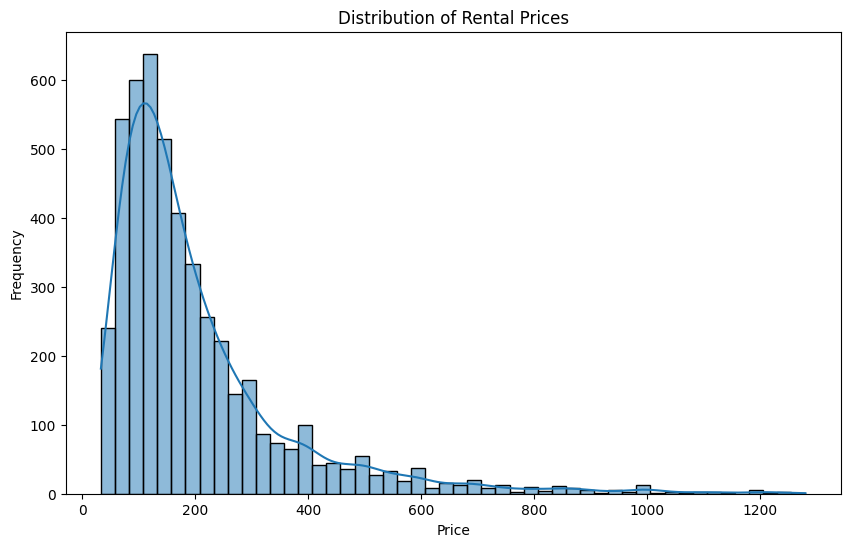

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['price'], kde=True, bins=50)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

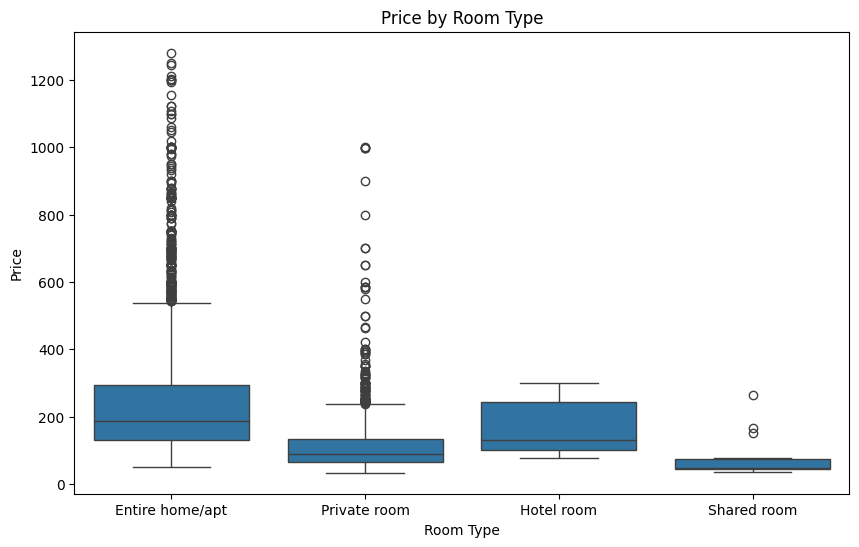

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df_cleaned)
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

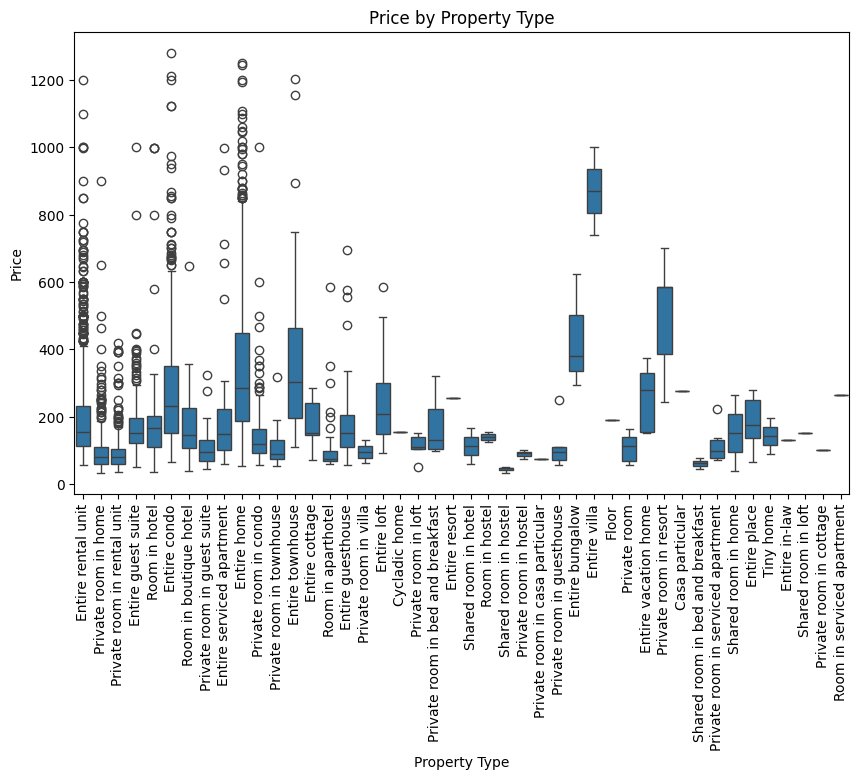

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='property_type', y='price', data=df_cleaned)
plt.title('Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

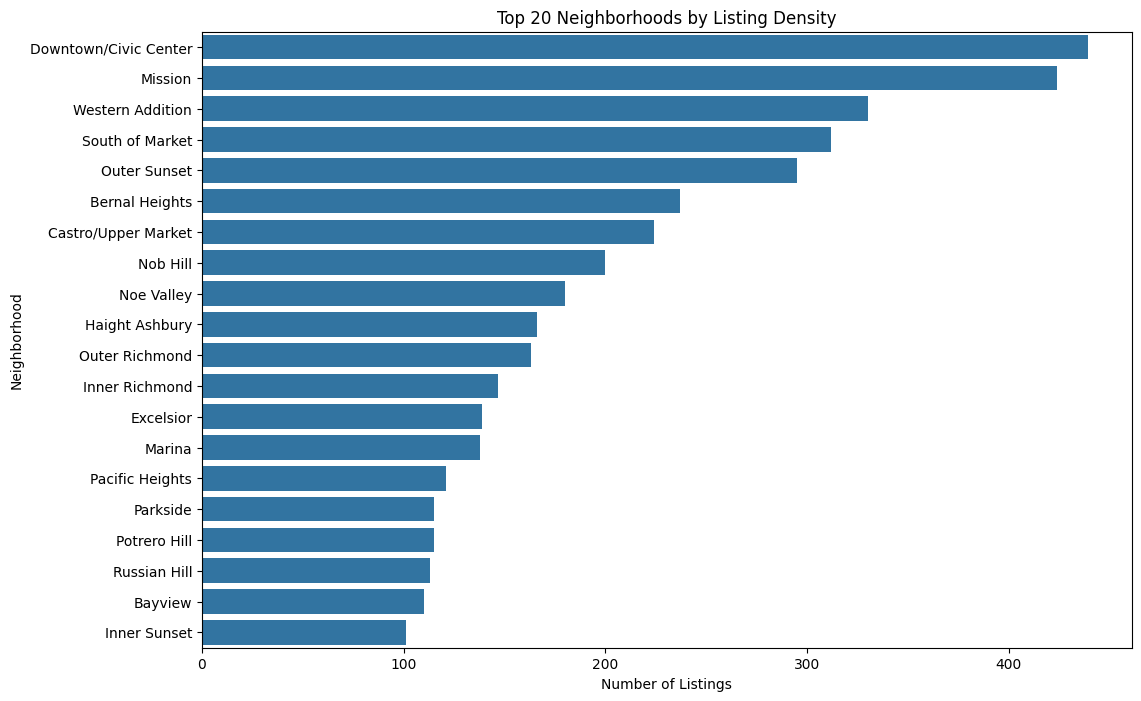

In [14]:
neighborhood_density = df_cleaned['neighbourhood_cleansed'].value_counts().reset_index()
neighborhood_density.columns = ['neighbourhood_cleansed', 'listings_count']

plt.figure(figsize=(12, 8))
sns.barplot(data=neighborhood_density.head(20), x='listings_count', y='neighbourhood_cleansed')
plt.title('Top 20 Neighborhoods by Listing Density')
plt.xlabel('Number of Listings')
plt.ylabel('Neighborhood')
plt.show()

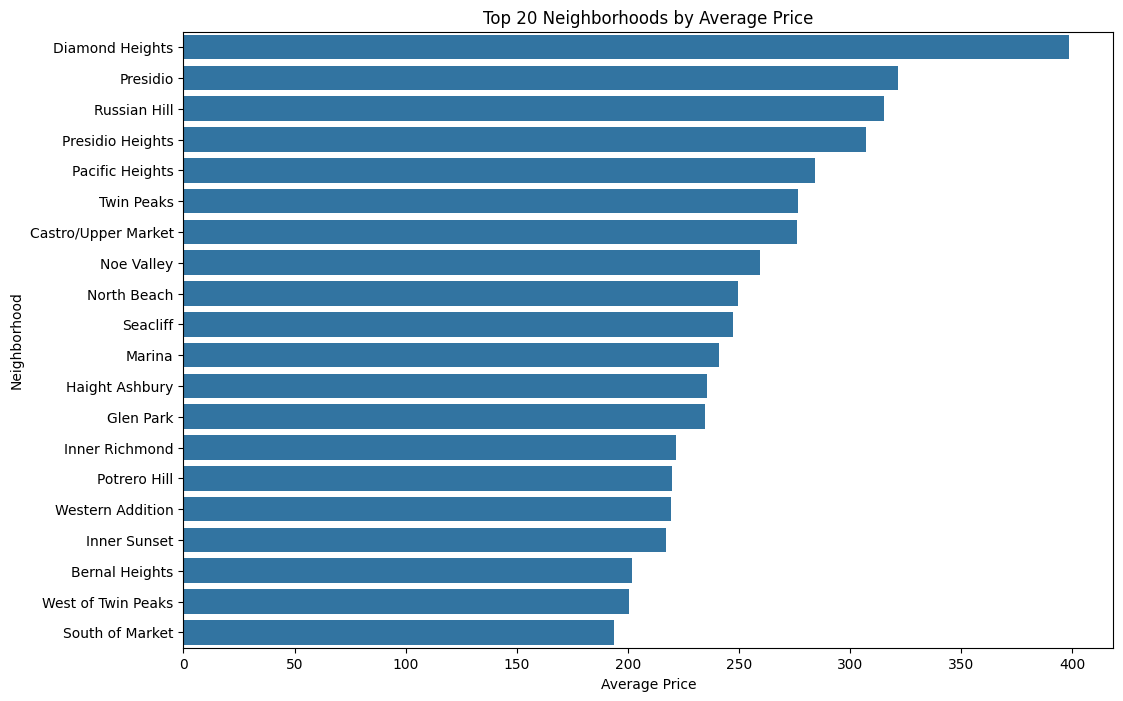

In [15]:
neighborhood_price = df_cleaned.groupby('neighbourhood_cleansed')['price'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=neighborhood_price.sort_values(by='price', ascending=False).head(20), x='price', y='neighbourhood_cleansed')
plt.title('Top 20 Neighborhoods by Average Price')
plt.xlabel('Average Price')
plt.ylabel('Neighborhood')
plt.show()

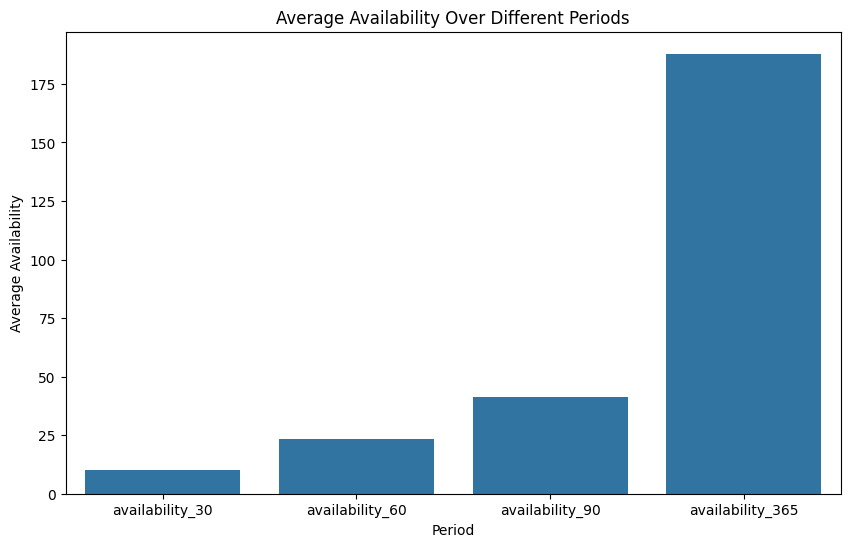

In [16]:
df_cleaned['occupancy_rate'] = 1 - df_cleaned['availability_365'] / 365

availability_columns = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
availability_data = df_cleaned[availability_columns].mean().reset_index()
availability_data.columns = ['Period', 'Average Availability']

plt.figure(figsize=(10, 6))
sns.barplot(data=availability_data, x='Period', y='Average Availability')
plt.title('Average Availability Over Different Periods')
plt.xlabel('Period')
plt.ylabel('Average Availability')
plt.show()

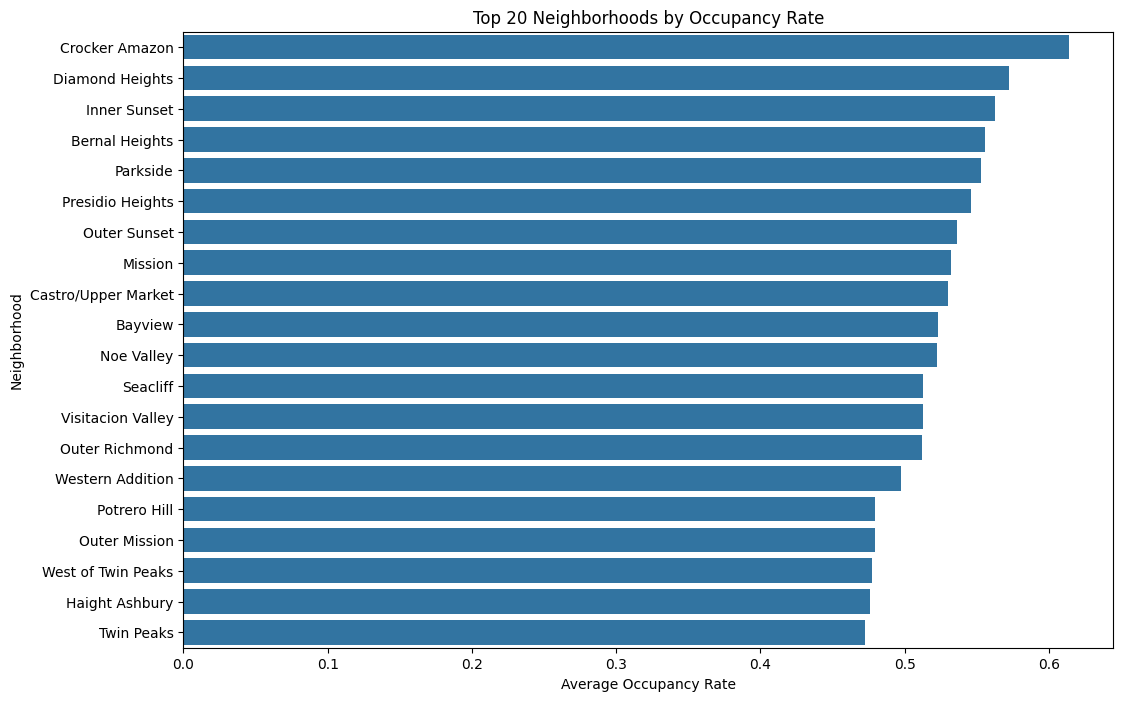

In [17]:
neighborhood_occupancy = df_cleaned.groupby('neighbourhood_cleansed')['occupancy_rate'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=neighborhood_occupancy.sort_values(by='occupancy_rate', ascending=False).head(20), x='occupancy_rate', y='neighbourhood_cleansed')
plt.title('Top 20 Neighborhoods by Occupancy Rate')
plt.xlabel('Average Occupancy Rate')
plt.ylabel('Neighborhood')
plt.show()

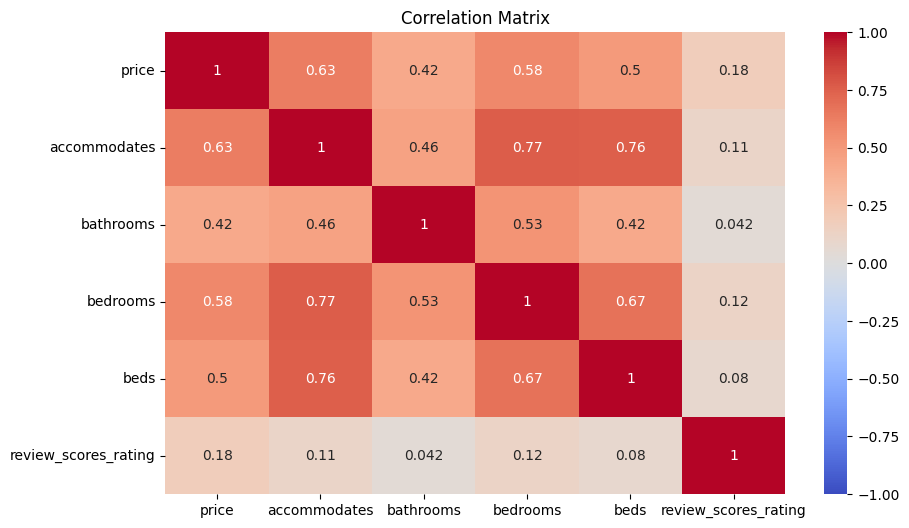

In [18]:
correlation_matrix = df_cleaned[['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Use MultiLabelBinarizer to create a binary matrix of amenities
df_cleaned['amenities'] = df_cleaned['amenities'].str.replace('[{}"]', '').str.split(',')
mlb = MultiLabelBinarizer()
amenities_binary = mlb.fit_transform(df['amenities'])
amenity_columns = mlb.classes_

# Create a DataFrame from the binarized amenities and add suffix '_amenity'
amenities_df = pd.DataFrame(amenities_binary, columns=[amenity + '_amenity' for amenity in amenity_columns])

# Combine the amenities with the original dataframe
df = df_cleaned.drop('amenities', axis=1).join(amenities_df)
# for col in df.columns:
#     print(col)

# Handle missing values in 'price' column
df = df.dropna(subset=['price', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'beds', 'review_scores_rating','neighbourhood_cleansed'])

features = ['property_type', 'room_type', 'accommodates', 'bathrooms', 'beds', 'review_scores_rating','neighbourhood_cleansed'] + list(amenities_df.columns)
X = pd.get_dummies(df[features], drop_first=True)
y = df['price']

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.coef_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

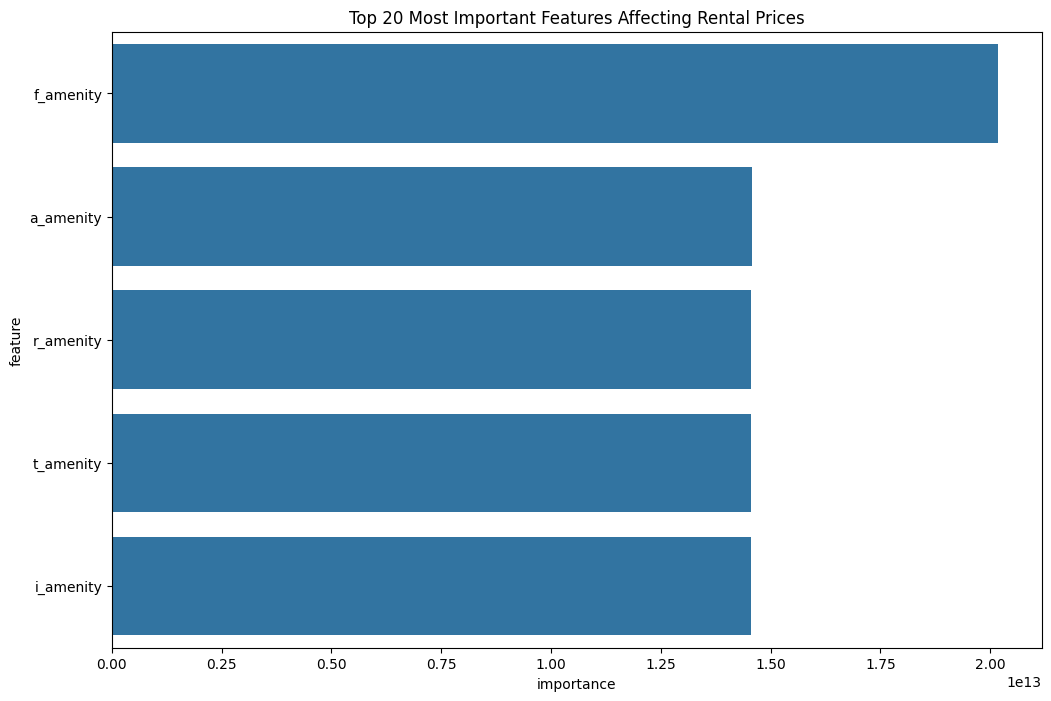

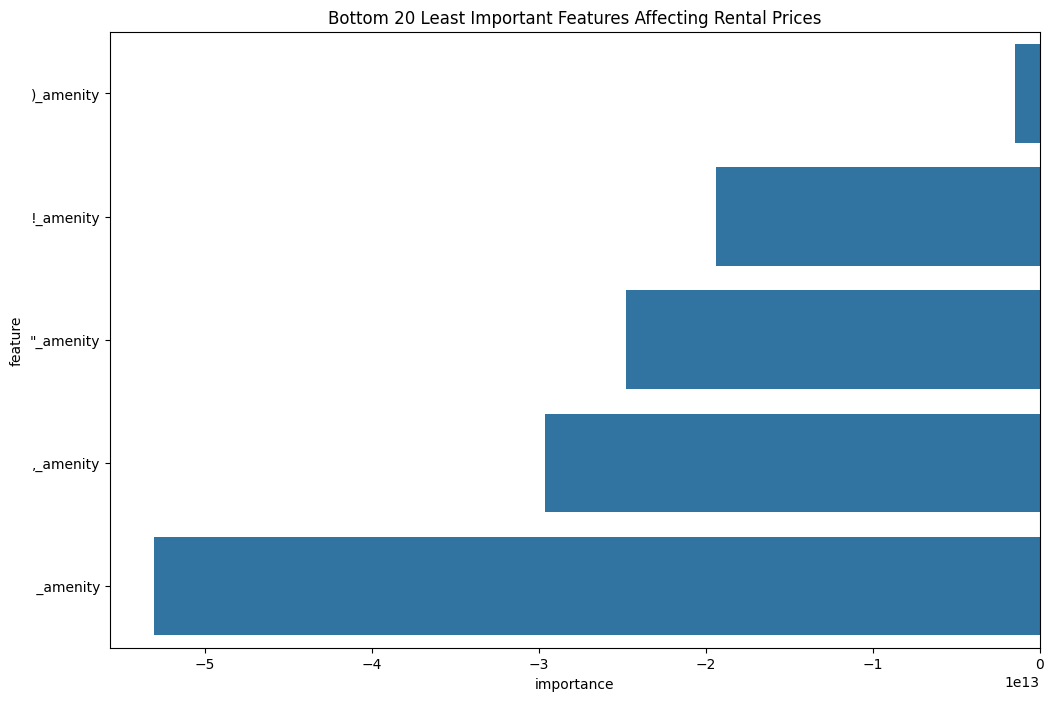

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(5), x='importance', y='feature')
plt.title('Top 20 Most Important Features Affecting Rental Prices')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.tail(5), x='importance', y='feature')
plt.title('Bottom 20 Least Important Features Affecting Rental Prices')
plt.show()